## Whats the big deal with imbalanced data?

In some cases, it can be very hard to learn from.

This notebook is an example implementation for a [blog post](jeremyjordan.me/imbalanced-data/) on learning from imbalanced data. Start there, and then come explore this notebook after familiarizing yourself with the various techniques.

In [1]:
from imblearn.datasets import fetch_datasets

datasets = fetch_datasets()

# Wine quality dataset contains 12 features, descriptions found here: 
# https://archive.ics.uci.edu/ml/datasets/wine+quality
# Target class derived as target: <=4 (score between 1 and 10)
data = datasets['wine_quality']
X, y = data.data, data.target

Check out a curated list of possible datasets here:
http://contrib.scikit-learn.org/imbalanced-learn/stable/datasets/index.html

In [2]:
# US crime dataset contains 100 features, descriptions found here: 
# http://archive.ics.uci.edu/ml/datasets/communities+and+crime
# Target class derived as target: >0.65

# Uncomment the lines below to try a different dataset
# data = datasets['us_crime']
# X, y = data.data, data.target

In [3]:
y = (y==1).astype(int)

#### Visualize dataset

Text(0.5, 1.0, 'Number of observations per class')

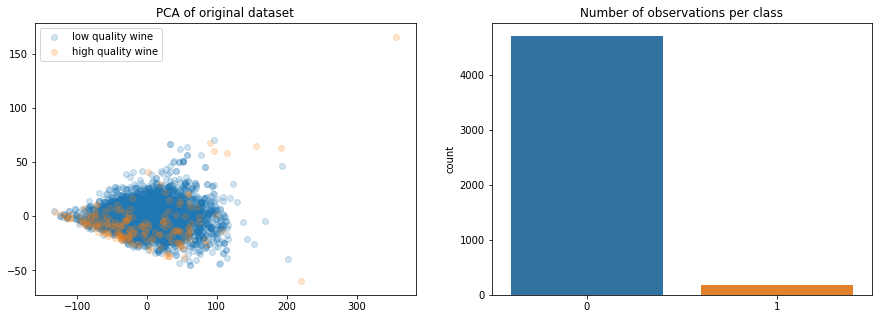

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
import seaborn as sns

# Reduce dataset to 2 feature dimensions in order to visualize the data
pca = PCA(n_components=2)
pca.fit(X)
X_reduced = pca.transform(X)

fig, ax = plt.subplots(1, 2, figsize= (15,5))

ax[0].scatter(X_reduced[y == 0, 0], X_reduced[y == 0, 1], label="low quality wine", alpha=0.2)
ax[0].scatter(X_reduced[y == 1, 0], X_reduced[y == 1, 1], label="high quality wine", alpha=0.2)
ax[0].set_title('PCA of original dataset')
ax[0].legend()

ax[1] = sns.countplot(y)
ax[1].set_title('Number of observations per class')

#### Train test split

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

## Build a pipeline for trying various sampling methods

In [6]:
from sklearn import metrics 
from collections import Counter

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, NearMiss, TomekLinks, EditedNearestNeighbours

def model_resampling_pipeline(X_train, X_test, y_train, y_test, model):
    results = {'ordinary': {},
               'class_weight': {},
               'oversample': {},
               'undersample': {}}
    
    # ------ No balancing ------
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, predictions)
    precision, recall, fscore, support = metrics.precision_recall_fscore_support(y_test, predictions)
    tn, fp, fn, tp = metrics.confusion_matrix(y_test, predictions).ravel()
    fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    
    results['ordinary'] = {'accuracy': accuracy, 'precision': precision, 'recall': recall, 
                          'fscore': fscore, 'n_occurences': support,
                          'predictions_count': Counter(predictions),
                          'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn,
                          'auc': auc}
    
    
    # ------ Class weight ------
    if 'class_weight' in model.get_params().keys():
        model.set_params(class_weight='balanced')
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        accuracy = metrics.accuracy_score(y_test, predictions)
        precision, recall, fscore, support = metrics.precision_recall_fscore_support(y_test, predictions)
        tn, fp, fn, tp = metrics.confusion_matrix(y_test, predictions).ravel()
        fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions, pos_label=1)
        auc = metrics.auc(fpr, tpr)

        results['class_weight'] = {'accuracy': accuracy, 'precision': precision, 'recall': recall, 
                                  'fscore': fscore, 'n_occurences': support,
                                  'predictions_count': Counter(predictions),
                                  'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn,
                                  'auc': auc}

    
    # ------------ OVERSAMPLING TECHNIQUES ------------
    print('------ Oversampling methods ------')
    techniques = [RandomOverSampler(),
                  SMOTE(),
                  ADASYN()]
    
    for sampler in techniques:
        technique = sampler.__class__.__name__
        print(f'Technique: {technique}')
        print(f'Before resampling: {sorted(Counter(y_train).items())}')
        X_resampled, y_resampled = sampler.fit_sample(X_train, y_train)
        print(f'After resampling: {sorted(Counter(y_resampled).items())}')

        model.fit(X_resampled, y_resampled)
        predictions = model.predict(X_test)
        accuracy = metrics.accuracy_score(y_test, predictions)
        precision, recall, fscore, support = metrics.precision_recall_fscore_support(y_test, predictions)
        tn, fp, fn, tp = metrics.confusion_matrix(y_test, predictions).ravel()
        fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions, pos_label=1)
        auc = metrics.auc(fpr, tpr)

        results['oversample'][technique] = {'accuracy': accuracy, 
                                            'precision': precision, 
                                            'recall': recall,
                                            'fscore': fscore, 
                                            'n_occurences': support,
                                            'predictions_count': Counter(predictions),
                                            'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn,
                                            'auc': auc}

    
    # ------------ UNDERSAMPLING TECHNIQUES ------------
    print('------ Undersampling methods ------')
    techniques = [RandomUnderSampler(),
                  NearMiss(version=1),
                  NearMiss(version=2),
                  TomekLinks(),
                  EditedNearestNeighbours()]
    
    for sampler in techniques:
        technique = sampler.__class__.__name__
        if technique == 'NearMiss': technique+=str(sampler.version)
        print(f'Technique: {technique}')
        print(f'Before resampling: {sorted(Counter(y_train).items())}')
        X_resampled, y_resampled = sampler.fit_sample(X_train, y_train)
        print(f'After resampling: {sorted(Counter(y_resampled).items())}')

        model.fit(X_resampled, y_resampled)
        predictions = model.predict(X_test)
        accuracy = metrics.accuracy_score(y_test, predictions)
        precision, recall, fscore, support = metrics.precision_recall_fscore_support(y_test, predictions)
        tn, fp, fn, tp = metrics.confusion_matrix(y_test, predictions).ravel()
        fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions, pos_label=1)
        auc = metrics.auc(fpr, tpr)

        results['undersample'][technique] = {'accuracy': accuracy, 
                                            'precision': precision, 
                                            'recall': recall,
                                            'fscore': fscore, 
                                            'n_occurences': support,
                                            'predictions_count': Counter(predictions),
                                            'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn,
                                            'auc': auc}
        

    return results

## Build tool to visualize results

In [7]:
def evaluate_method(results, method, metrics = ['precision', 'recall', 'fscore']):
    fig, ax = plt.subplots(1, 7, sharey=True, figsize=(16, 6))
    
    for i, metric in enumerate(metrics):
        ax[i*2].axhline(results['ordinary'][metric][0], label='No Resampling')
        ax[i*2+1].axhline(results['ordinary'][metric][1], label='No Resampling')
        
        if results['class_weight']:
            ax[i*2].bar(0, results['class_weight'][metric][0], label='Adjust Class Weight')
            ax[i*2+1].bar(0, results['class_weight'][metric][1], label='Adjust Class Weight')
            
        ax[0].legend(loc='upper center', bbox_to_anchor=(9, 1.01),
                     ncol=1, fancybox=True, shadow=True)
        
        for j, (technique, result) in enumerate(results[method].items()):
            ax[i*2].bar(j+1, result[metric][0], label=technique)
            
            ax[i*2+1].bar(j+1, result[metric][1], label=technique)
        
        
        ax[i*2].set_title(f'Low quality wine: \n{metric}')
        ax[i*2+1].set_title(f'High quality wine: \n{metric}')
    
    # AUC vis
    ax[6].set_title(f'Area under curve')
    ax[6].axhline(results['ordinary']['auc'], label='No Resampling')
    if results['class_weight']:
        ax[6].bar(0, results['class_weight']['auc'], label='Adjust Class Weight')
    for j, (technique, result) in enumerate(results[method].items()):
        ax[6].bar(j+1, result['auc'], label=technique)

## Try some models

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

## Decision tree

Visualize a decision tree trained on imbalanced data.

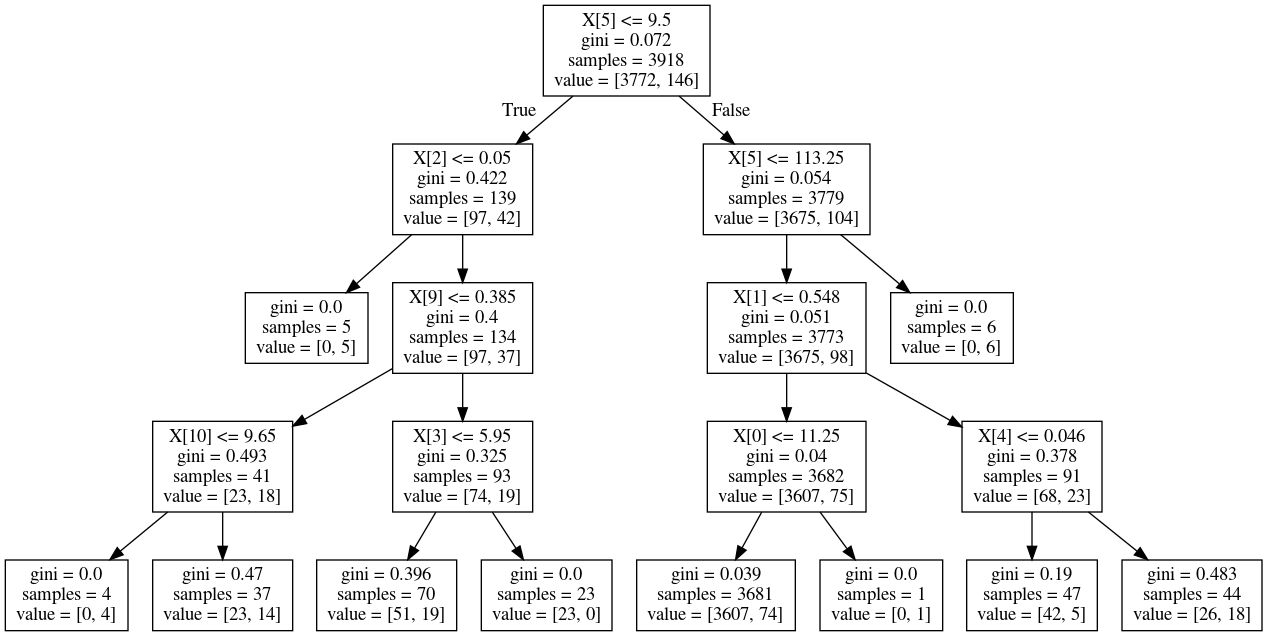

In [12]:
model = DecisionTreeClassifier(max_depth=4)
model.fit(X_train, y_train)

from IPython.display import Image  
from sklearn.externals.six import StringIO  
import pydot  
from sklearn import tree

dot_data = StringIO()  
tree.export_graphviz(model, out_file=dot_data)
graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph[0].create_png())

In [13]:
model = DecisionTreeClassifier()
results = model_resampling_pipeline(X_train, X_test, y_train, y_test, model)

------ Oversampling methods ------
Technique: RandomOverSampler
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 3772), (1, 3772)]
Technique: SMOTE
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 3772), (1, 3772)]
Technique: ADASYN
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 3772), (1, 3748)]
------ Undersampling methods ------
Technique: RandomUnderSampler
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 146), (1, 146)]
Technique: NearMiss1
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 146), (1, 146)]
Technique: NearMiss2
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 146), (1, 146)]
Technique: TomekLinks
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 3723), (1, 146)]
Technique: EditedNearestNeighbours
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 3507), (1, 146)]


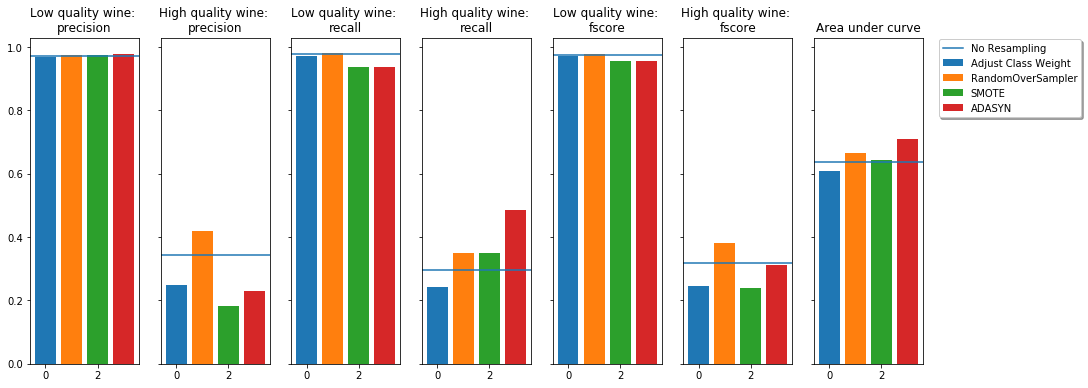

In [14]:
evaluate_method(results, 'oversample')

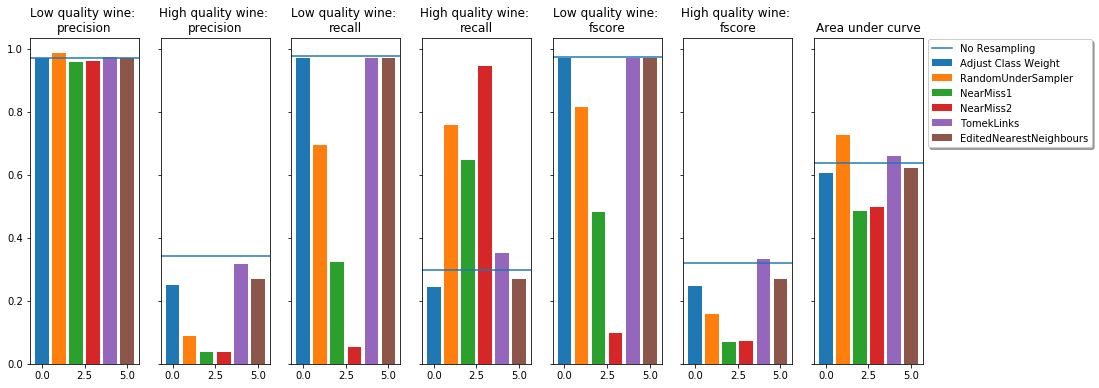

In [15]:
evaluate_method(results, 'undersample')

## Random forest

In [16]:
model = RandomForestClassifier()
results = model_resampling_pipeline(X_train, X_test, y_train, y_test, model)

/home/huy/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


------ Oversampling methods ------
Technique: RandomOverSampler
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 3772), (1, 3772)]
Technique: SMOTE
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 3772), (1, 3772)]
Technique: ADASYN
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 3772), (1, 3748)]
------ Undersampling methods ------
Technique: RandomUnderSampler
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 146), (1, 146)]
Technique: NearMiss1
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 146), (1, 146)]
Technique: NearMiss2
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 146), (1, 146)]
Technique: TomekLinks
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 3723), (1, 146)]
Technique: EditedNearestNeighbours
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 3507), (1, 146)]


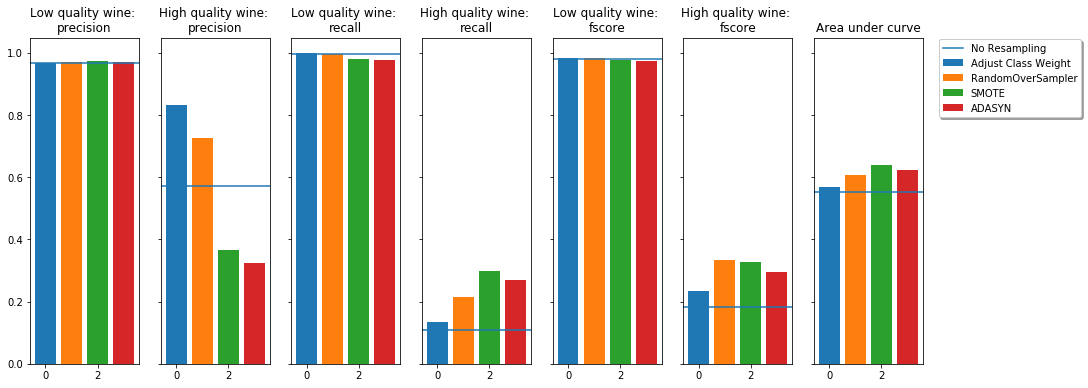

In [17]:
evaluate_method(results, 'oversample')

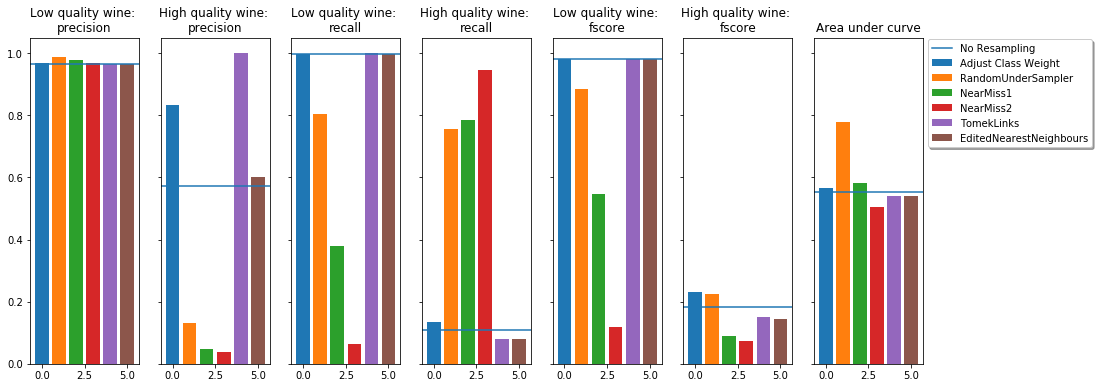

In [18]:
evaluate_method(results, 'undersample')

## Logistic regression

In [19]:
model = LogisticRegression()
results = model_resampling_pipeline(X_train, X_test, y_train, y_test, model)

/home/huy/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/huy/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


------ Oversampling methods ------
Technique: RandomOverSampler
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 3772), (1, 3772)]
Technique: SMOTE
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 3772), (1, 3772)]
Technique: ADASYN
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 3772), (1, 3748)]


/home/huy/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/huy/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/huy/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


------ Undersampling methods ------
Technique: RandomUnderSampler
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 146), (1, 146)]
Technique: NearMiss1
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 146), (1, 146)]
Technique: NearMiss2
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 146), (1, 146)]
Technique: TomekLinks
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 3723), (1, 146)]
Technique: EditedNearestNeighbours
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 3507), (1, 146)]


/home/huy/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/huy/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/huy/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/huy/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/huy/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Spec

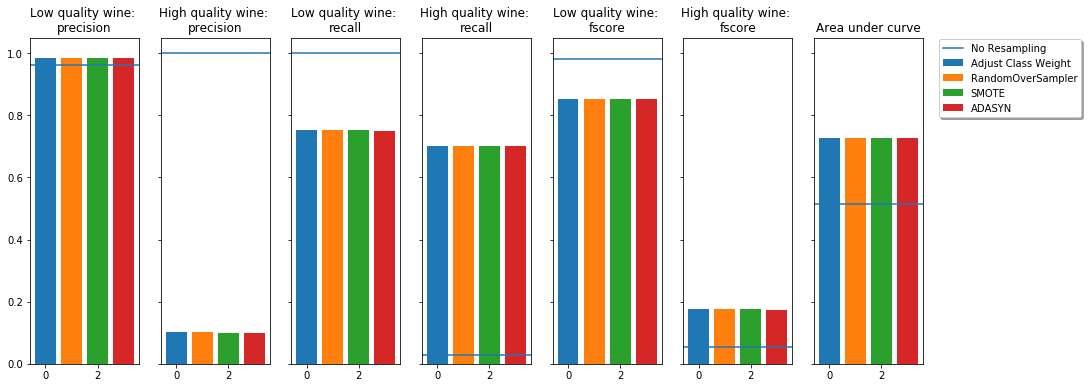

In [20]:
evaluate_method(results, 'oversample')

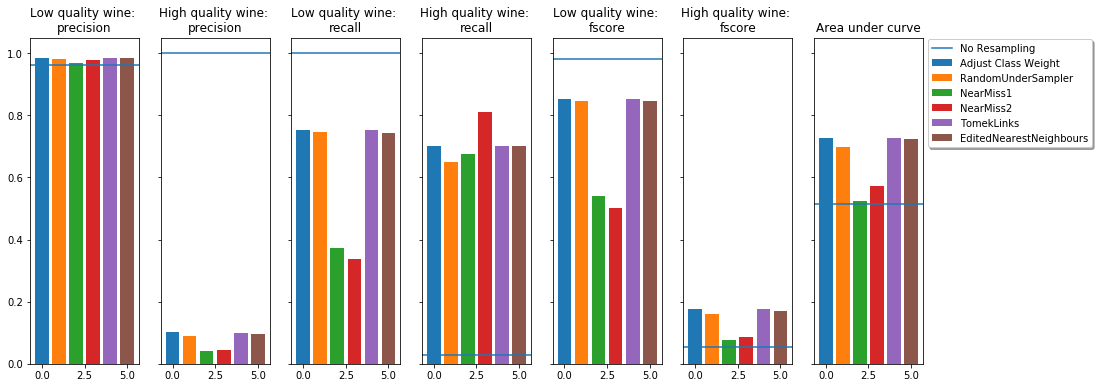

In [21]:
evaluate_method(results, 'undersample')

## SVM Classifier

In [22]:
model = SVC()
results = model_resampling_pipeline(X_train, X_test, y_train, y_test, model)

/home/huy/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/huy/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/huy/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


------ Oversampling methods ------
Technique: RandomOverSampler
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 3772), (1, 3772)]


/home/huy/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Technique: SMOTE
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 3772), (1, 3772)]


/home/huy/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Technique: ADASYN
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 3772), (1, 3748)]


/home/huy/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


------ Undersampling methods ------
Technique: RandomUnderSampler
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 146), (1, 146)]
Technique: NearMiss1
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 146), (1, 146)]
Technique: NearMiss2
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 146), (1, 146)]
Technique: TomekLinks
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 3723), (1, 146)]


/home/huy/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/huy/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/huy/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/huy/anaconda3/lib/python3.7/site-packages/sklearn/svm/base

Technique: EditedNearestNeighbours
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 3507), (1, 146)]


/home/huy/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


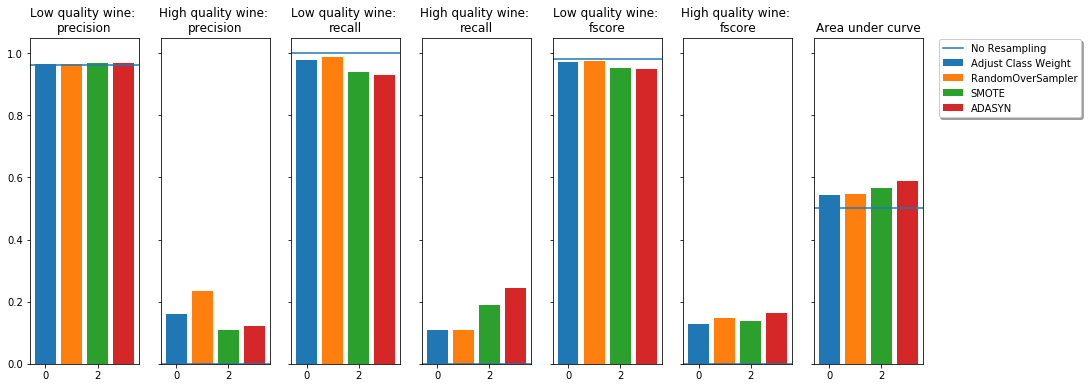

In [23]:
evaluate_method(results, 'oversample')

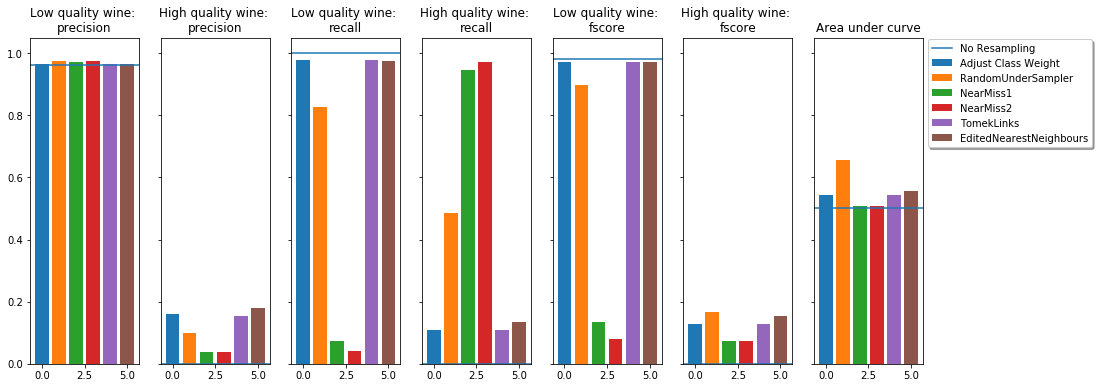

In [24]:
evaluate_method(results, 'undersample')

## KNN

In [25]:
model = KNeighborsClassifier()
results = model_resampling_pipeline(X_train, X_test, y_train, y_test, model)

------ Oversampling methods ------
Technique: RandomOverSampler
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 3772), (1, 3772)]
Technique: SMOTE
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 3772), (1, 3772)]
Technique: ADASYN
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 3772), (1, 3748)]
------ Undersampling methods ------
Technique: RandomUnderSampler
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 146), (1, 146)]
Technique: NearMiss1
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 146), (1, 146)]
Technique: NearMiss2
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 146), (1, 146)]
Technique: TomekLinks
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 3723), (1, 146)]
Technique: EditedNearestNeighbours
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 3507), (1, 146)]


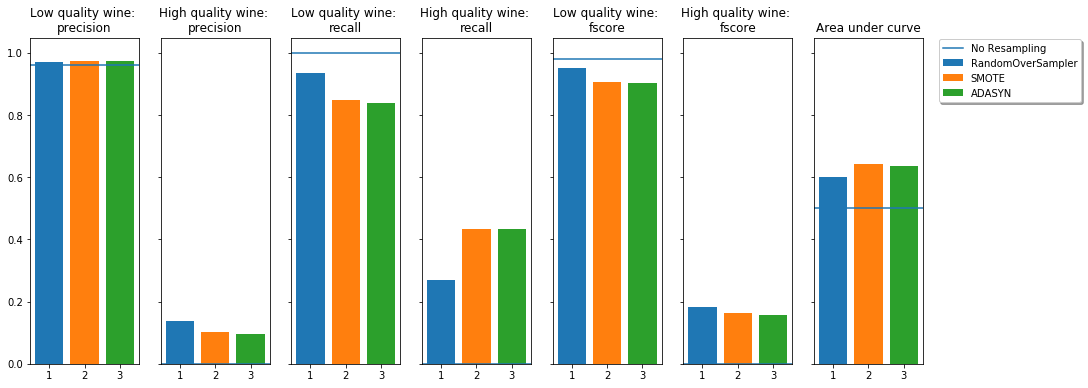

In [26]:
evaluate_method(results, 'oversample')

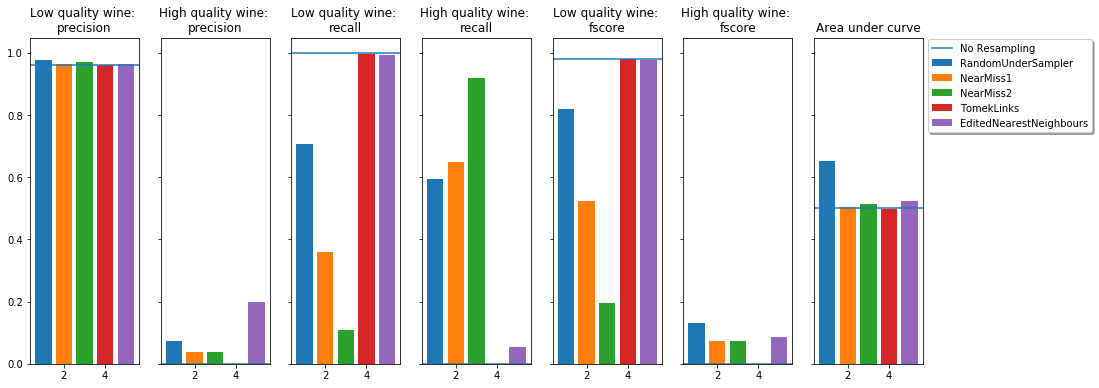

In [27]:
evaluate_method(results, 'undersample')

## AdaBoost Classifier

In [28]:
model = AdaBoostClassifier()
results = model_resampling_pipeline(X_train, X_test, y_train, y_test, model)

------ Oversampling methods ------
Technique: RandomOverSampler
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 3772), (1, 3772)]
Technique: SMOTE
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 3772), (1, 3772)]
Technique: ADASYN
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 3772), (1, 3748)]
------ Undersampling methods ------
Technique: RandomUnderSampler
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 146), (1, 146)]
Technique: NearMiss1
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 146), (1, 146)]
Technique: NearMiss2
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 146), (1, 146)]
Technique: TomekLinks
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 3723), (1, 146)]
Technique: EditedNearestNeighbours
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 3507), (1, 146)]


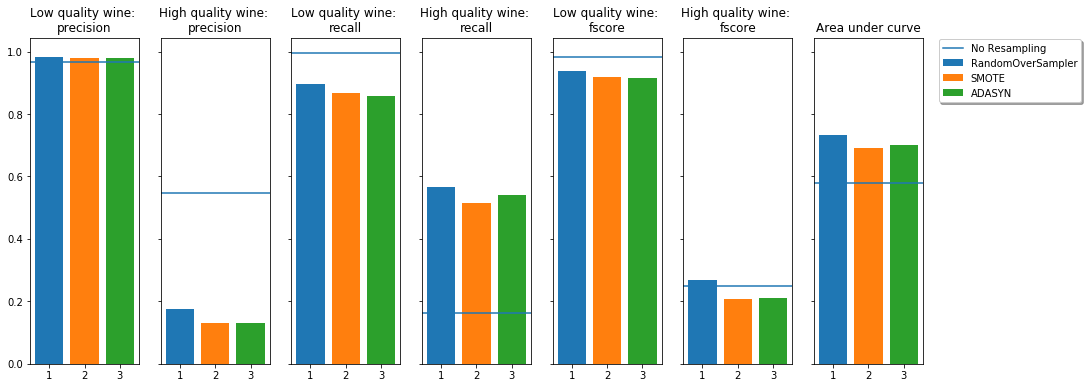

In [29]:
evaluate_method(results, 'oversample')

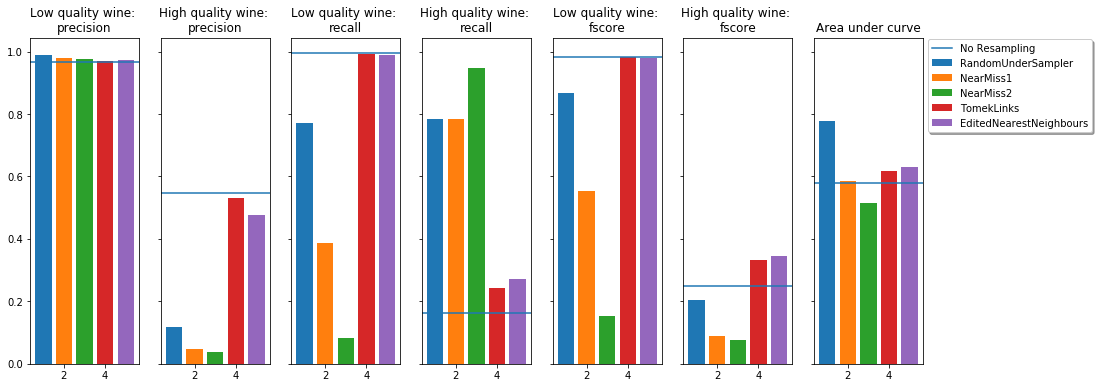

In [30]:
evaluate_method(results, 'undersample')

## Simple neural network

In [31]:
model = MLPClassifier(hidden_layer_sizes=(50, 50), activation='relu', solver='lbfgs')
results = model_resampling_pipeline(X_train, X_test, y_train, y_test, model)

------ Oversampling methods ------
Technique: RandomOverSampler
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 3772), (1, 3772)]
Technique: SMOTE
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 3772), (1, 3772)]
Technique: ADASYN
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 3772), (1, 3748)]
------ Undersampling methods ------
Technique: RandomUnderSampler
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 146), (1, 146)]
Technique: NearMiss1
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 146), (1, 146)]
Technique: NearMiss2
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 146), (1, 146)]
Technique: TomekLinks
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 3723), (1, 146)]
Technique: EditedNearestNeighbours
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 3507), (1, 146)]


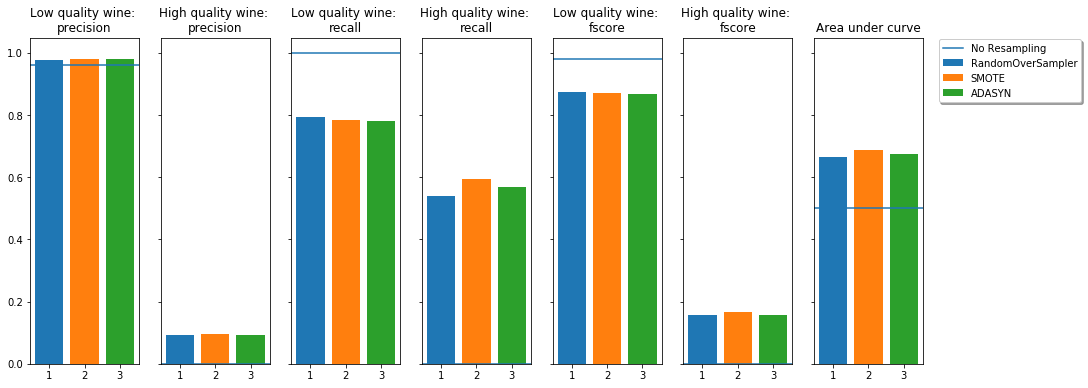

In [32]:
evaluate_method(results, 'oversample')

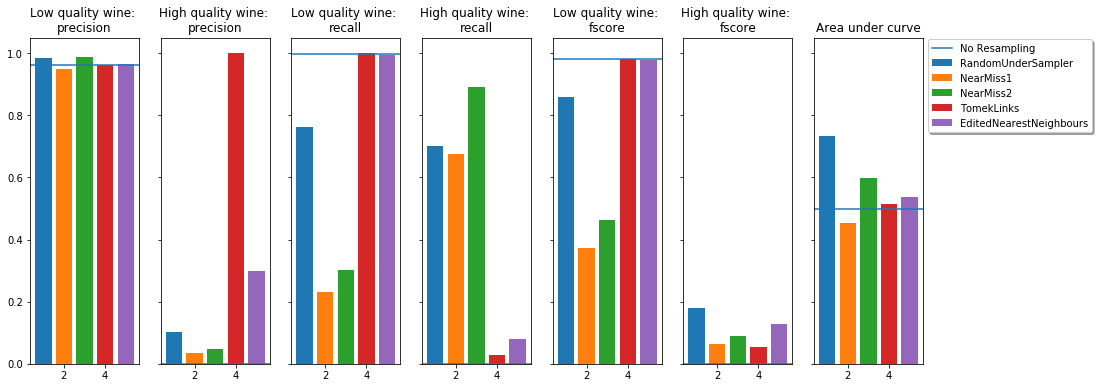

In [33]:
evaluate_method(results, 'undersample')

# Techniques

A reminder of the techniques discussed in my post.

## Class weight

One of the simplest ways to address the class imbalance is to simply provide a weight for each class which places more emphasis on the minority classes such that the end result is a classifier which can learn equally from all classes. 

To calculate the proper weights for each class, you can use the sklearn utility function shown in the example below.
```
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced', classes, y)
```

In a tree-based model where you're determining the optimal split according to some measure such as decreased entropy, you can simply scale the entropy component of each class by the corresponding weight such that you place more emphasis on the minority classes. As a reminder, the entropy of a node can be calculated as

$$ \mathop - \sum \limits_i^{}  {p_i}{\log}\left( {{p_i}} \right) $$ 

where $p_i$ is the fraction of data points within class $i$.

In a gradient-based model, you can scale the calculated loss for each observation by the appropriate class weight such that you place more significance on the losses associated with minority classes. As a reminder, a common loss function for classification is the categorical cross entropy (which is very similar to the above equation, albeit with slight differences). This may be calculated as 

 $$ -\sum_i y_i \log \hat{y}_ i $$
 
 where $y_i$ represents the true class (typically a one-hot encoded vector) and $\hat{y}_ i$ represents the predicted class distribution. 

## Oversampling
Another approach towards dealing with a class imbalance is to simply alter the dataset to remove such an imbalance. In this section, I'll discuss common techniques for *oversampling* the minority classes to increase the number of minority observations until we've reached a balanced dataset. 

#### Random oversampling
The most naive method of oversampling is to randomly sample the minority classes and simply duplicate the sampled observations. With this technique, it's important to note that you're artificially reducing the variance of the dataset. 

#### Generating new data points (oversampling)

There are two approaches supported for generating new data points, `SMOTE` (Synthetic Minority Over-sampling Technique) and `ADASYN` (Adaptive Synthetic Sampling). Both techniques use interpolation to generate new datapoints. 

For a given observation $x_i$, a new (synthetic) observation is generated by interpolating between one of the k-nearest neighbors, $x_{zi}$.

$$x_{new} = x_i + \lambda (x_{zi} - x_i)$$

where $\lambda$ is a random number in the range $\left[ {0,1} \right]$. This interpolation will create a sample on the line between $x_{i}$ and $x_{zi}$.

<img src="http://contrib.scikit-learn.org/imbalanced-learn/stable/_images/sphx_glr_plot_illustration_generation_sample_0011.png" alt="Drawing" style="width: 400px;"/>

<small>[Image credit](http://contrib.scikit-learn.org/imbalanced-learn/stable/_images/sphx_glr_plot_illustration_generation_sample_0011.png)</small>


#### SMOTE
Synthetic Minority Over-sampling Technique (SMOTE) is a technique that generates new observations by interpolating between observations in the original dataset.

This algorithm has three options for selecting which observations, $x_i$, to use in generating new data points.

1. `regular`: No selection rules, randomly sample all possible $x_i$.
2. `borderline`: Separates all possible $x_i$ into three classes using the k nearest neighbors of each point.
    - *noise*: all nearest-neighbors are from a different class than $x_i$
    - *in danger*: at least half of the nearest neighbors are of the same class as $x_i$
    - *safe*: all nearest neighbors are from the same class as $x_i$
3. `svm`: Uses an SVM classifier to identify the support vectors (samples close to the decision boundary) and samples $x_i$ from these points.

#### ADASYN
Adaptive Synthetic (ADASYN) sampling works in a similar manner as SMOTE, however, the number of samples generated for a given $x_i$ is proportional to the number of nearby samples which **do not** belong to the same class as $x_i$. Thus, ADASYN tends to focus solely on outliers when generating new synthetic training examples. 

## Undersampling
Rather than oversampling the minority classes, it's also possible to achieve class balance by *undersampling* the majority class - essentially throwing away data to make it easier to learn characteristics about the minority classes.  

#### Random undersampling
As with oversampling, a naive implementation would be to simply sample the majority class at random until reaching a similar number of observations as the minority classes. For example, if your majority class has 1,000 observations and you have a minority class with 20 observations, you would collect your training data for the majority class by randomly sampling 20 observations from the original 1,000. As you might expect, this could potentially result in removing key characteristics of the majority class.

#### Near miss
The general idea behind near miss is to only the sample the points from the majority class necessary to distinguish between other classes.

**NearMiss-1** select samples from the majority class for which the average distance of the N *closest* samples of a minority class is smallest. 

<img src="http://contrib.scikit-learn.org/imbalanced-learn/stable/_images/sphx_glr_plot_illustration_nearmiss_0011.png" alt="Drawing" style="width: 400px;"/>


<small>[Image credit](http://contrib.scikit-learn.org/imbalanced-learn/stable/under_sampling.html)</small>

**NearMiss-2** select samples from the majority class for which the average distance of the N *farthest* samples of a minority class is smallest. 

<img src="http://contrib.scikit-learn.org/imbalanced-learn/stable/_images/sphx_glr_plot_illustration_nearmiss_0021.png" alt="Drawing" style="width: 400px;"/>

<small>[Image credit](http://contrib.scikit-learn.org/imbalanced-learn/stable/under_sampling.html)</small>



#### Tomeks links
A Tomek’s link is defined as two observations of different classes ($x$ and $y$) such that there is no example $z$ for which:

$$d(x, z) < d(x, y) \text{ or } d(y, z) < d(x, y)$$

where $d()$ is the distance between the two samples. **In other words, a Tomek’s link exists if two observations of different classes are the nearest neighbors of each other.** In the figure below, a Tomek’s link is illustrated by highlighting the samples of interest in green.

<img src="http://contrib.scikit-learn.org/imbalanced-learn/stable/_images/sphx_glr_plot_illustration_tomek_links_0011.png" alt="Drawing" style="width: 400px;"/>

<small>[Image credit](http://contrib.scikit-learn.org/imbalanced-learn/stable/under_sampling.html)</small>


For this undersampling strategy, we'll remove any observations *from the majority class* for which a Tomek's link is identified. Depending on the dataset, this technique won't actually achieve a balance among the classes - it will simply "clean" the dataset by removing some noisy observations, which may result in an easier classification problem. 

#### Edited nearest neighbors
EditedNearestNeighbours applies a nearest-neighbors algorithm and “edit” the dataset by removing samples which do not agree “enough” with their neighboorhood. For each sample in the class to be under-sampled, the nearest-neighbours are computed and if the selection criterion is not fulfilled, the sample is removed.

This is a similar approach as Tomek's links in the respect that we're not necessarily focused on actually achieving a class balance, we're simply looking to remove noisy observations in an attempt to make for an easier classification problem. 